In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import mixed_precision

from tqdm import tqdm_notebook as tqdm

import copy

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import PhaseOnlyReconstruction

import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

2024-02-20 00:02:06.433199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.lz4'
sample_data_path = f'{data_path}/sample_{strain_type}.lz4'

save_plots = False

In [4]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
#sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


## simulations_per_peakstructing the phases/ separate magnitudes

In [5]:
recons = PhaseOnlyReconstruction(simulation=sm, shared_magnitudes=False)
                                 #phases_init=phases_init, magnitudes_init=magnitudes_init)

2024-02-20 00:03:01.540369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38178 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Setting background_level to 1e-08...


2024-02-20 00:03:03.290157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]
2024-02-20 00:03:03.290434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]


In [6]:
phases_lr = 1e-2
magnitude_lr = 1e-1
if not 'phases_v' in recons.optimizers:
    recons.setPhaseAdamOptimizer(phases_lr)
else:
    recons.optimizers['phases_v']['learning_rate'].assign(phases_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

#recons.optimizers

In [7]:
recons.minimize(1000, debug_output_epoch_frequency=10)

Initializing the datalog...


2024-02-20 00:03:06.576619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'iters_before_registration' with dtype int32
	 [[{{node iters_before_registration}}]]


Instructions for updating:
Use fn_output_signature instead


2024-02-20 00:03:16.833624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'iters_before_registration' with dtype int32
	 [[{{node iters_before_registration}}]]
2024-02-20 00:03:37.638618: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x14a438002a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 00:03:37.638661: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-02-20 00:03:37.643782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 00:03:37.723148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
202

        epoch  train_loss   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
60         10    3.51e+07      0.941      0.899      0.873      0.911          0.955          0.887          0.854           0.91
120         20   8.98e+06      0.966      0.925      0.872      0.898      0.975      0.919       0.85      0.894
180         30   1.49e+06      0.885      0.699      0.856       0.88      0.848      0.681      0.823      0.876
240         40   1.31e+06      0.875      0.633      0.935      0.892      0.817      0.616      0.853      0.883
300         50   8.87e+05       0.86      0.594      0.937      0.898      0.798      0.574      0.868      0.886
360         60    7.9e+05       0.85      0.562      0.936      0.897       0.79      0.541      0.879      0.879
420         70   5.73e+05      0.809      0.541      0.908      0.894      0.792      0.523      0.872      0.877
480         80   4.43e+05       0.75      0.524      0.8

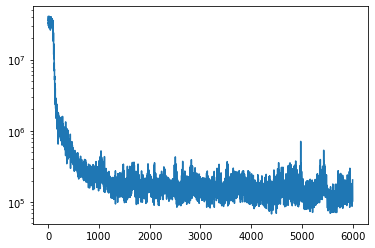

In [8]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [9]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/.conda/envs/tf2/lib/python3.9/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is 

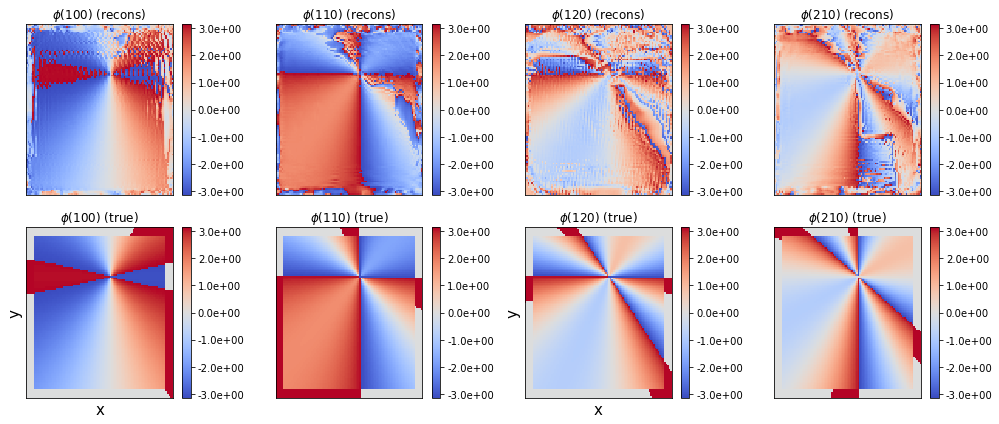

In [10]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

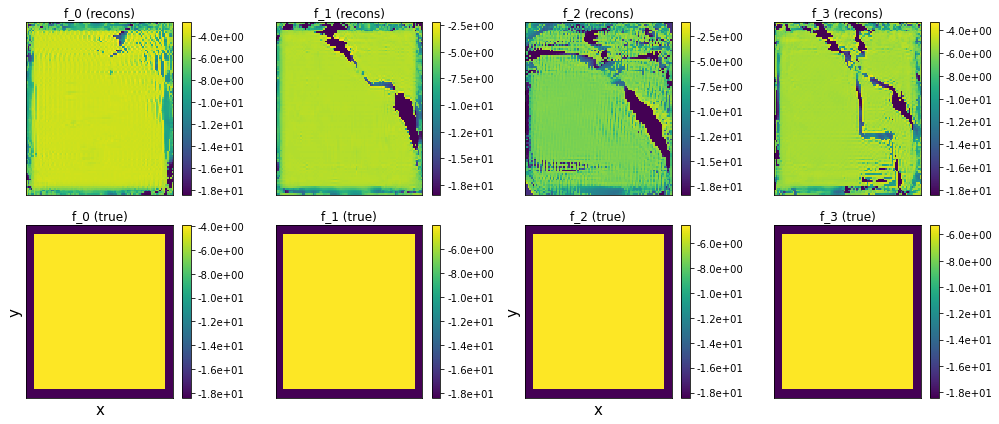

In [11]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = 1e-8 + np.abs(recons.rho_2d[i])#[10:-10,10:-10])
    true_amplitudes = 1e-8 + np.abs(recons._rho_true[i])#[10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [12]:
recons.saveOutputsAndLog(data_path)

rhos saved in /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//rho_phase_sep_mags.npz
dataframe saved in /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//df_phase_sep_mags.gz


In [13]:
phases_init = np.angle(recons.rho_2d)
magnitudes_init = np.abs(recons.rho_2d)

## Convert phases to displacements

In [14]:
from mbptycho.code.recons.recons import DisplacementFromPhaseReconstruction

In [15]:
recons2 = DisplacementFromPhaseReconstruction(simulation=sm, phases_init=phases_init)

In [16]:
recons2.minimize()

Initializing the datalog...
       epoch     err_ux     err_uy  err_ux_film  err_uy_film
1          1      0.758      0.913        0.698        0.832


2024-02-20 00:42:22.352559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [17]:

true_items = {}
recons2_items = {}

if recons2._model_type != 'phase':
    recons2_items[r"$\alpha_x$"] = recons2.ux_2d - recons2.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons2._ux_true - recons2._ux_true.mean() 

    recons2_items[r"$\alpha_y$"] = recons2.uy_2d - recons2.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons2._uy_true - recons2._uy_true.mean()


if not recons2._model_type == 'displacement_to_phase':

    for i in range(recons2.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons2._rho_true[i], recons2.rho_2d[i], upsample_factor=10)
        recons2_items[labelstr] = np.angle(recons2.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons2._rho_true[i])

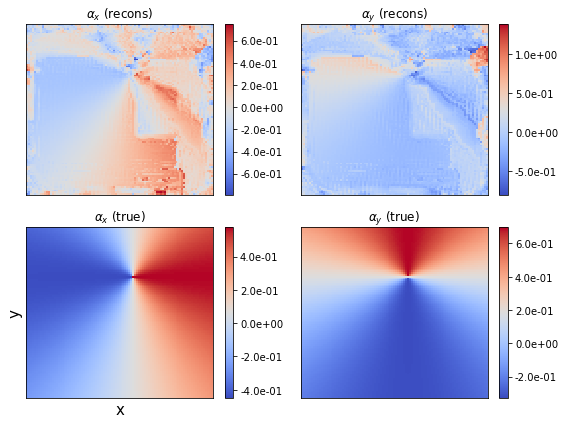

In [18]:
save_plots = False
if recons2._model_type == 'phase':
    subplots_x = recons2.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons2._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons2.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons2_suffix = recons2._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons2_items.items()):
    if i == 0 and recons2._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons2._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons2._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

In [19]:
recons2.saveOutputsAndLog(data_path)

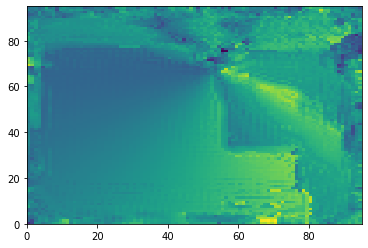

In [20]:
plt.pcolormesh(recons2.ux_2d)

In [21]:

import matplotlib.colors as colors

In [22]:
ux = recons2_items[r'$\alpha_x$']
uy = recons2_items[r'$\alpha_y$']

In [23]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

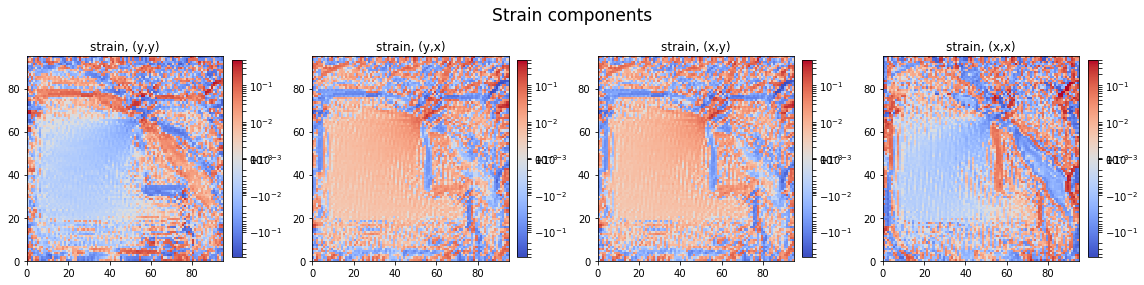

In [24]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.5, vmax=0.5))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  